In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve, KFold
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
bikes_test = pd.read_excel('bike_test.xlsx')
bikes_train = pd.read_excel('bike_train.xlsx')

In [7]:
bikes_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11999 entries, 0 to 11998
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     11999 non-null  int64         
 1   dteday      11999 non-null  datetime64[ns]
 2   season      11999 non-null  int64         
 3   yr          11999 non-null  int64         
 4   mnth        11999 non-null  int64         
 5   hr          11999 non-null  int64         
 6   holiday     11999 non-null  int64         
 7   weekday     11999 non-null  int64         
 8   workingday  11999 non-null  int64         
 9   weathersit  11999 non-null  int64         
 10  temp        11999 non-null  float64       
 11  atemp       11999 non-null  float64       
 12  hum         11999 non-null  float64       
 13  windspeed   11999 non-null  float64       
 14  casual      11999 non-null  int64         
 15  registered  11999 non-null  int64         
 16  cnt         11999 non-

In [13]:
bikes_train.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000
mean,6000.000000,2.210684,0.279523,5.530294,11.556630,0.027752,3.009334,0.684057,1.435036,0.465704,0.448888,0.625770,0.196433,30.049837,128.545129,158.594966
std,3463.957275,1.088798,0.448784,3.433005,6.911891,0.164269,2.005264,0.464910,0.650894,0.188576,0.169633,0.200637,0.125394,43.596915,124.692750,151.392952
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3000.500000,1.000000,0.000000,3.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.320000,0.303000,0.470000,0.104500,3.000000,29.000000,34.000000
50%,6000.000000,2.000000,0.000000,5.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.460000,0.454500,0.620000,0.194000,13.000000,98.000000,118.000000
75%,8999.500000,3.000000,1.000000,8.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.620000,0.590900,0.790000,0.283600,39.000000,185.000000,232.000000
max,11999.000000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,0.960000,1.000000,1.000000,0.850700,367.000000,770.000000,957.000000


some data like workingday leaning towards 1 is interesting, need to see what's going on there

In [9]:
bikes_train.isna().any()

instant       False
dteday        False
season        False
yr            False
mnth          False
hr            False
holiday       False
weekday       False
workingday    False
weathersit    False
temp          False
atemp         False
hum           False
windspeed     False
casual        False
registered    False
cnt           False
dtype: bool

No nulls

In [8]:
bikes_train.nunique()

instant       11999
dteday          506
season            4
yr                2
mnth             12
hr               24
holiday           2
weekday           7
workingday        2
weathersit        4
temp             48
atemp            65
hum              88
windspeed        30
casual          287
registered      623
cnt             713
dtype: int64

No extra values in columns like weekday and month

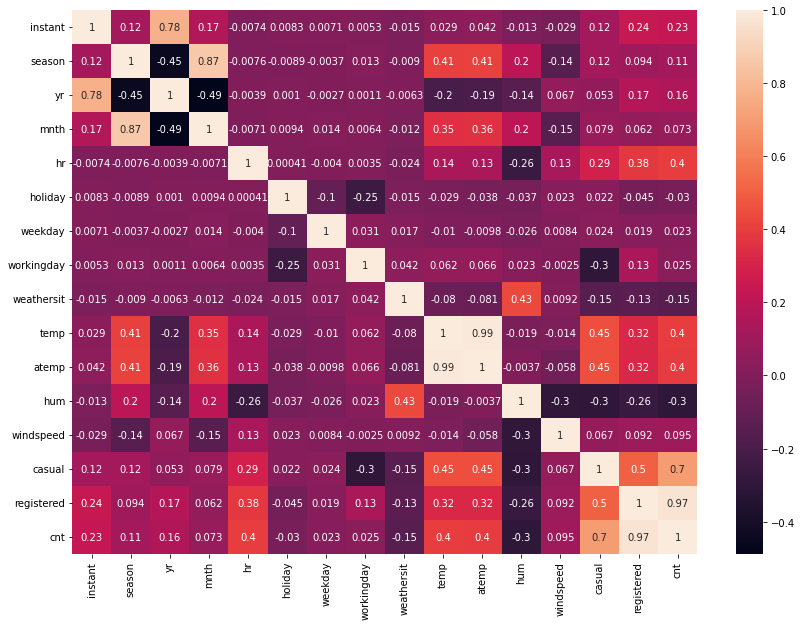

In [12]:
plt.figure(figsize=(14,10))
sns.heatmap(bikes_train.corr(), annot=True)
plt.show()

variables like temp and atemp are highly correlated

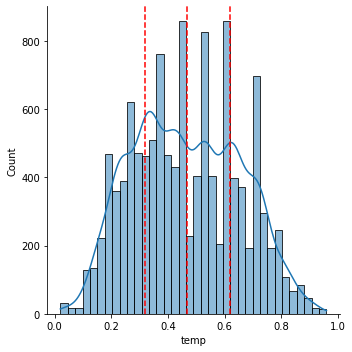

In [17]:
sns.displot(x="temp", data=bikes_train, kde=True)
description = bikes_train['temp'].describe()
plt.axvline(description["25%"], ls="--", color='r')
plt.axvline(description["mean"], ls="--", color='r')
plt.axvline(description["75%"], ls="--", color='r')

the distribution seems normal, less people go out at both extremes

In [20]:
fig = px.box(bikes_train, x="season", y="cnt", color="season", width=1000, height=600)

def custom_legend_name(new_names):
    for i, new_name in enumerate(new_names):
        fig.data[i].name = new_name

custom_legend_name(['season 1','season 2','season 3','season 4' ])
fig.show()

(1: spring, 2: summer, 3: fall, 4: winter)
We can see the most number of people rent bikes in summer and the least in winter

In [23]:
fig = px.bar(bikes_train, x='season', y='cnt', color="season")
fig.show()

same as above

<AxesSubplot:xlabel='workingday', ylabel='cnt'>

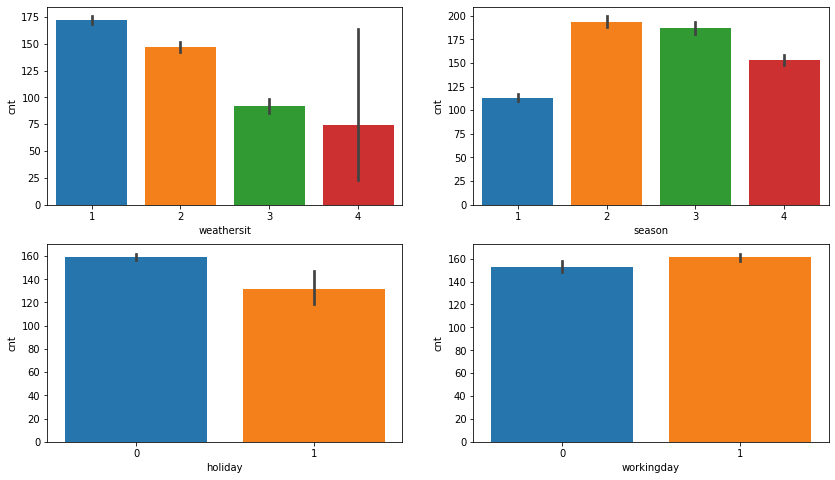

In [26]:
fig, ax = plt.subplots(2,2, figsize = (14,8))
sns.barplot(x = 'weathersit', y = 'cnt', data = bikes_train, saturation=0.90, ax = ax[0][0])
sns.barplot(x = 'season', y = 'cnt', data = bikes_train,  saturation=0.90, ax = ax[0][1])
sns.barplot(x = 'holiday', y = 'cnt', data = bikes_train, saturation=0.90, ax = ax[1][0])
sns.barplot(x = 'workingday', y = 'cnt', data = bikes_train,  saturation=0.90, ax = ax[1][1])

###### Information :- 
            
| Barplot                         | Information                                                                   |
| ------------------------------| ------------------------------------------------------------------------------|
| weather vs Count       | When weather is 1 (Clear, Partly cloudy) then count is highest.               |
| season vs Count        | In season 3 ( fall ) we have highest number of count & least in 1 (spring). |
| holiday vs Count       | In holiday (1) time we have least number of count. Makes sense since holidays are the minority.                            |
| workingday vs Count    | In working day ( Neighter holiday/ weekend) we have highest number of count. Again, non working days are the minority  |

In [3]:
bikes_train_temp = bikes_train.copy()
bikes_train_temp = bikes_train_temp.drop(["instant", "yr", "atemp", "casual","registered","dteday"], axis=1)

In [4]:
bikes_test_temp = bikes_test.copy()
bikes_test_temp = bikes_test_temp.drop(["instant", "yr", "atemp", "dteday"], axis=1)

In [5]:
bikes_train_temp.head()

,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,1,1,0,0,6,0,1,0.24,0.81,0.0,16
1,1,1,1,0,6,0,1,0.22,0.80,0.0,40
2,1,1,2,0,6,0,1,0.22,0.80,0.0,32
3,1,1,3,0,6,0,1,0.24,0.75,0.0,13
4,1,1,4,0,6,0,1,0.24,0.75,0.0,1


In [6]:
bikes_test_temp.head()

,season,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed
0,2,5,4,0,0,0,1,0.52,0.68,0.0896
1,2,5,5,0,0,0,1,0.50,0.72,0.1045
2,2,5,6,0,0,0,1,0.50,0.63,0.1343
3,2,5,7,0,0,0,1,0.52,0.68,0.1940
4,2,5,8,0,0,0,1,0.56,0.56,0.1642


In [31]:
y = bikes_train_temp["cnt"]
X = bikes_train_temp.drop("cnt", axis=1)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state=42)

In [33]:
xg_model = XGBRegressor()
xg_scores = cross_val_score(xg_model, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)

In [34]:
rmse = np.sqrt(-xg_scores)
rmse

array([6.96128766, 6.96108762, 7.14637588, 7.11864735, 6.8257026 ,
       6.93436269, 7.26072291, 7.42015815, 7.17109995, 7.03594511])

In [35]:
np.mean(rmse).round()

7.0

In [36]:
xg_model.fit(X_train, y_train)
xg_model_prediction = xg_model.predict(X_test)

In [37]:
print('R2 Score: ', r2_score(y_test, xg_model_prediction)*100)
print('RMSE: ', np.sqrt(mean_squared_error(y_test, xg_model_prediction)))

R2 Score:  89.21969238508282
RMSE:  48.782666634006596


In [42]:
xg_model_prediction_proper = xg_model.predict(bikes_test_temp)

In [44]:
xg_model_prediction_proper

array([ 15.400438 ,   6.1870584,  11.985815 , ...,  44.316    ,
        35.13337  , -15.092947 ], dtype=float32)

In [45]:
xg_model_prediction_proper = [abs(n) for n in xg_model_prediction_proper]
xg_model_prediction_proper

[15.400438,
 6.1870584,
 11.985815,
 49.91487,
 188.0948,
 237.31346,
 344.60107,
 411.03473,
 451.46,
 528.4249,
 540.2811,
 538.7328,
 548.7326,
 469.23004,
 396.5573,
 316.74225,
 229.02817,
 140.96178,
 134.66586,
 28.329147,
 2.257413,
 11.8196535,
 9.373965,
 10.301345,
 22.278433,
 9.551431,
 10.986968,
 100.31347,
 320.5382,
 180.76984,
 92.04153,
 165.36005,
 156.67847,
 138.05795,
 148.24962,
 199.66333,
 315.1781,
 556.53174,
 563.1386,
 395.16278,
 270.43484,
 189.25029,
 140.3292,
 73.60404,
 38.487167,
 21.189787,
 11.263946,
 9.578331,
 11.750112,
 14.113189,
 64.990814,
 216.12529,
 464.61465,
 254.4979,
 150.4695,
 167.20789,
 178.36276,
 203.28395,
 181.96227,
 231.05939,
 319.984,
 612.4966,
 602.27875,
 459.4526,
 337.60562,
 236.25632,
 170.15959,
 96.28855,
 46.838802,
 24.888489,
 38.935078,
 15.498508,
 11.212352,
 13.542607,
 118.032135,
 366.2871,
 516.2155,
 302.5951,
 175.00813,
 193.3826,
 258.88867,
 259.33438,
 229.90222,
 277.31454,
 352.64606,
 603.7342

In [46]:
prototype = pd.DataFrame()
prototype['pred'] = xg_model_prediction_proper
prototype.to_csv('KevinG91.csv', index= False)